# Importing results from a GAMS model to an IamDataFrame

This tutorial illustrates how to extract results from any GAMS model (via the gdx file)
and cast them to an **IamDataFrame** for further processing.

<img style="float: right; margin: 10px;" src="_static/gams_logo.png">

The workflow presented here uses the **gdxtools** package
([read the docs](https://github.com/boxblox/gdxtools)):

1. Manually install the GAMS API,
   follow one of the options in [this description](https://www.gams.com/latest/docs/API_PY_TUTORIAL.html).

2. Install the **gdxtools** package via
   ```
   pip install gdxtools
   ```

****

**Developers note:**
Running this notebook on CI and RTD is a challenge
due to the need to download and install the GAMS API.
For the time being, this notebook is not executed by `nbsphinx`
and has to be saved with output.

In [1]:
import pandas as pd
import pyam
import gdxtools

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


## The transport model

The model used for this illustration is the transport model by Rosenthal,
frequently used for tutorials and examples.

The complete model is repeated here for clarity - note the last line
which exports the results to a file in the GAMS Data Exchange (gdx) format.

    *Basic example of transport model from GAMS model library

    $Title  A Transportation Problem (TRNSPORT,SEQ=1)
    $Ontext

    This problem finds a least cost shipping schedule that meets
    requirements at markets and supplies at factories.

    Dantzig, G B, Chapter 3.3. In Linear Programming and Extensions.
    Princeton University Press, Princeton, New Jersey, 1963.

    This formulation is described in detail in:
    Rosenthal, R E, Chapter 2: A GAMS Tutorial. In GAMS: A User's Guide.
    The Scientific Press, Redwood City, California, 1988.

    $Offtext

    Sets
         i   canning plants   / seattle, san-diego /
         j   markets          / new-york, chicago, topeka / ;
    Parameters
         a(i)  capacity of plant i in cases
           /    seattle     350
                san-diego   600  /
         b(j)  demand at market j in cases
           /    new-york    325
                chicago     300
                topeka      275  / ;
    Table d(i,j)  distance in thousands of miles
                      new-york       chicago      topeka
        seattle          2.5           1.7          1.8
        san-diego        2.5           1.8          1.4  ;
    Scalar f  freight in dollars per case per thousand miles  /90/ ;
    Parameter c(i,j)  transport cost in thousands of dollars per case ;
              c(i,j) = f * d(i,j) / 1000 ;
    Variables
         x(i,j)  shipment quantities in cases
         z       total transportation costs in thousands of dollars ;

    Positive Variable x ;

    Equations
         cost        define objective function
         supply(i)   observe supply limit at plant i
         demand(j)   satisfy demand at market j ;

    cost ..        z  =e=  sum((i,j), c(i,j)*x(i,j)) ;

    supply(i) ..   sum(j, x(i,j))  =l=  a(i) ;

    demand(j) ..   sum(i, x(i,j))  =g=  b(j) ;

    Model transport /all/ ;

    Solve transport using lp minimizing z ;

    Display x.l, x.m ;

    Execute_unload 'transport_out.gdx';

## Import results from the gdx file

The next cell imports the results of the transport model from the gdx file.  
The subsequent cell defines a utility function to translate the GAMS symbol
into a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

The basic transport model does not have a temporal resolution,
but an IamDataFrame requires some information in the time domain.
We therefore assume that the year is 2010 and add it to the results.
In a more elaborate model, "time" or "year" would be in the symbol domain

In [2]:
gdx = gdxtools.gdxrw.gdxReader('transport_out.gdx')

In [3]:
def gdx_to_pandas(gdx, symbol, attribute='level'):
    """Utility function to parse a GamsSymbol and cast it to a pandas.DataFrame"""

    symbol = gdx.rgdx(name=symbol)

    if symbol['domain']:  # translate symbol with dimensions
        keys = symbol['values'].keys()
        values = [symbol['values'][k][attribute] for k in keys]
        df = pd.DataFrame(data=values, index=keys).reset_index()
        df.columns = symbol['domain'] + ['value']

    else:  # translate symbol with dimension 0
        df = pd.DataFrame([symbol['values'][attribute]], columns=['value'])

    # in a more elaborate model, 'time'/'year' would be in the symbol domain
    df['year'] = 2010

    return df

## Cast results to an IamDataFrame

The first cell in this section defines the model and scenario identifiers,
which are identical for all results.

In [4]:
args = dict(model='transport', scenario='baseline')

### The objective value

The value of the objective function is added as a variable `Cost`.  
The subsequent cell shows the first row of the IamDataFrame,
to which we will then add more processed results.

In [5]:
df = pyam.IamDataFrame(gdx_to_pandas(gdx, 'z'),
                       variable='cost', region='USA', unit='$', **args)

In [6]:
df.timeseries()

,,,,,2010
model,scenario,region,variable,unit,
transport,baseline,USA,cost,$,153.675


### Optimal shipment of quantities

The shipments determined by the model can be read from the value
(GAMS-speak: "level") of the decision variable `x`.
The first cell in this section reads the dataframe from the results and displays it.

In [7]:
x = gdx_to_pandas(gdx, 'x')
x

,i,j,value,year
0,seattle,new-york,50.0,2010
1,seattle,chicago,300.0,2010
2,seattle,topeka,0.0,2010
3,san-diego,new-york,275.0,2010
4,san-diego,chicago,0.0,2010
5,san-diego,topeka,275.0,2010


There are several ways to coerce the "from-to" dimension of the mathematical formulation
to the "variable/region" format used in the IAMC data standard.
In this example, we define a variable "supply|\\<origin\\>" and use the demand center as the region.

This is implemented by adding a column 'type' to the shipment-dataframe
and appending a new object to the results IamDataFrame concatening the 'type' column and the orgin column 'i'.

In [8]:
x['type'] = 'supply'

In [9]:
df.append(x, variable=['type', 'i'], region='j', unit='cases', **args, inplace=True)

### Market prices at the demand centers

The market prices can be determined from the marginal value of the demand-constraint equations.

In [10]:
df.append(gdx_to_pandas(gdx, 'demand', attribute='marginal'),
          variable='market price', region='j', unit='$/case', **args, inplace=True)

In [11]:
df.timeseries()

2010
model     scenario region   variable         unit           
transport baseline USA      cost             $       153.675
                   chicago  market price     $/case    0.153
                            supply|san-diego cases     0.000
                            supply|seattle   cases   300.000
                   new-york market price     $/case    0.225
                            supply|san-diego cases   275.000
                            supply|seattle   cases    50.000
                   topeka   market price     $/case    0.126
                            supply|san-diego cases   275.000
                            supply|seattle   cases     0.000

## Postprocessing to compute aggregate results

It is often practical to not only have results at the most disaggregated level,
but to also add aggregated results to the output.
The **pyam** package offers several utilities to perform aggregation or validation;
the following cell computes the total supply to each demand city
and appends it to the results-IamDataFrame.

The second cell again displays the results-IamDataFrame to illustrate the aggregation feature.

In [12]:
df.aggregate('supply', append=True)

In [13]:
df.timeseries()

2010
model     scenario region   variable         unit           
transport baseline USA      cost             $       153.675
                   chicago  market price     $/case    0.153
                            supply           cases   300.000
                            supply|san-diego cases     0.000
                            supply|seattle   cases   300.000
                   new-york market price     $/case    0.225
                            supply           cases   325.000
                            supply|san-diego cases   275.000
                            supply|seattle   cases    50.000
                   topeka   market price     $/case    0.126
                            supply           cases   275.000
                            supply|san-diego cases   275.000
                            supply|seattle   cases     0.000

## Visualization of results

The **pyam** package includes a powerful plotting and visualization library.
Most features are geared for timeseries data (for plotting development over time),
but some are useful even for this small, stylized application:
the next cell shows the regional share of supply from the two supply locations
to the three demand centers.

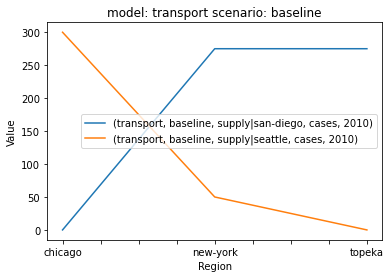

In [14]:
df.filter(variable='supply|*').line_plot(x='region')

## Exporting to different file formats

You can use **pyam** to export the processed data in the IAMC format as an Excel table.

In [15]:
df.to_excel('transport.xlsx')

**pyam** also supports export to different file formats,
for example the [frictionless data package](https://frictionlessdata.io)!

In [16]:
df.to_datapackage('transport.zip')

<div class="alert alert-info">

**Questions?**
Take a look at [this tutorial](https://pyam-iamc.readthedocs.io/en/stable/tutorials/pyam_first_steps.html) for *first steps with pyam* - then join our [mailing list](https://groups.io/g/pyam)!

</div>